# Exercises from 2_Linear_Classification Notebook

In [17]:
# imports for evrth

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

<hr>

## (A) Linear Regression

#### Questions

1. Develop the Softmax classifier using a dataset of your choice. See [this module](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) from PyTorch.
2. Develop a model to solve this regression task (below). Consider adding at least two layers and a non-linearity to the model.

### 1. Develop the Softmax classifier using a dataset of your choice.

It will be used the Iris dataset, more suitable for a multi-class classification tasks, where the output is a probability distribution over multiple classes.

### Steps:
* Load and preprocess the dataset (Iris dataset).
* Define the Softmax classifier using PyTorch.
* Train the classifier using the training data.
* Evaluate the model on a test set.
* Visualize the results.

In [18]:
import torch.nn as nn # neural network, it's a sub-library of pytorch which contains many different components for neural network
import torch.nn.functional as F

### Dataset

The Iris dataset has 4 features and 3 classes. The dataset is split into training and test sets.

The features are normalized using `StandardScaler` to improve training performance.

In [3]:
# Step 1: Load and preprocess the Iris dataset
iris = load_iris()
X = iris['data']  # Features
y = iris['target']  # Labels (0, 1, 2)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Step 2: Create a PyTorch Dataset and DataLoader for batching
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = IrisDataset(X_train, y_train)
test_data = IrisDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

### Model

A simple linear layer maps the input features to the number of classes. The `CrossEntropyLoss` function applies Softmax internally, so we don't need to explicitly apply Softmax in the model.

In [ ]:
# Step 3: Define the Softmax Classifier model
class SoftmaxClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(SoftmaxClassifier, self).__init__()
        # A linear layer with output size equal to the number of classes
        self.linear = nn.Linear(num_features, num_classes)

    def forward(self, x):
        logits = self.linear(x)
        return logits  # Softmax is applied inside CrossEntropyLoss

# Initialize the model
num_features = X_train.shape[1]  # Number of input features (4 for the Iris dataset)
num_classes = len(np.unique(y))  # Number of classes (3 for the Iris dataset)

model = SoftmaxClassifier(num_features, num_classes)

# Step 4: Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Combines LogSoftmax and NLLLoss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Move model to GPU if available
device = torch.device("cpu")
model.to(device)

### Training 

The model is trained for 100 epochs, and the loss is printed every 10 epochs.

In [ ]:
# Step 5: Train the model
def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, optimizer, criterion)

### Evaluation

The model's accuracy is evaluated on the test set, with the accuracy printed after evaluation.

In [ ]:
# Step 6: Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

evaluate_model(model, test_loader)

### Visualization

The dataset is reduced to 2 dimensions and plot the decision boundary to visualize how the Softmax classifier divides the feature space.

In [ ]:
# Step 7: Visualize decision boundaries (2D projection)
def plot_decision_boundary(model, X, y):
    model.eval()
    
    # Project the data onto a 2D plane (for visualization)
    X = X[:, :2].cpu().numpy()
    y = y.cpu().numpy()

    # Generate a grid of points
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Make predictions over the grid
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        logits = model(grid_points)
        _, Z = torch.max(logits, 1)
    Z = Z.cpu().reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Spectral)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary for Softmax Classifier')
    plt.show()

# Reduce the dataset to 2 features for visualization purposes
X_train_2D = X_train[:, :2]
model_2D = SoftmaxClassifier(2, num_classes).to(device)
train_model(model_2D, DataLoader(IrisDataset(X_train_2D, y_train), batch_size=16), optimizer, criterion)

# Plot decision boundary
plot_decision_boundary(model_2D, X_train_2D, y_train)

# decision boundary plot for a Softmax classifier, applied to a 2D projection of the Iris dataset 

In the plot, the different regions represent the decision boundaries where the classifier predicts different classes. Each color corresponds to a different class, and the points represent the data samples, with colors denoting the true class labels.

The classifier has learned to separate the feature space into three regions, with boundaries that aim to divide the data according to the class probabilities. From this visualization, it looks like the Softmax classifier has effectively captured the relationships between the two selected features and their respective classes.

### 2. Develop a model to solve this regression task below. 
Consider adding at least two layers and a non-linearity to the model.

In [ ]:
""" # Consider the following dataset
from sklearn.datasets import make_regression # a simpler way to create regression data
x, y = make_regression(n_samples=1000, n_features=1, noise=0.2)
y = np.power(y,2)
plt.show() """

Since the target variable 𝑦 has been squared (y = np.power(y, 2)), this adds non-linearity to the problem, the model will include non-linear activation functions.

Epoch [50/500], Loss: 107920.5078
Epoch [100/500], Loss: 105010.6719
Epoch [150/500], Loss: 98166.6172
Epoch [200/500], Loss: 86385.5391
Epoch [250/500], Loss: 70786.1094
Epoch [300/500], Loss: 55017.8203
Epoch [350/500], Loss: 43049.5273
Epoch [400/500], Loss: 35256.7930
Epoch [450/500], Loss: 29699.1230
Epoch [500/500], Loss: 25330.3184


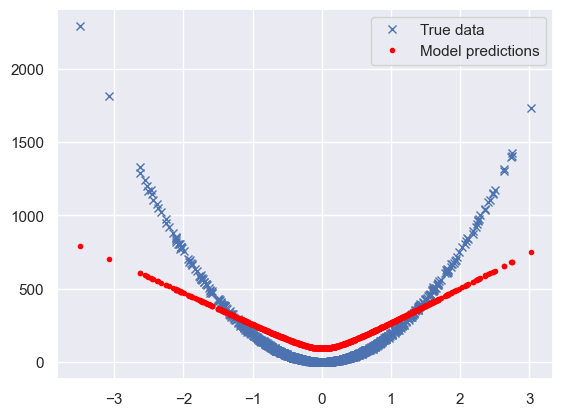

In [19]:
from sklearn.datasets import make_regression

# Step 1: Create the dataset
x, y = make_regression(n_samples=1000, n_features=1, noise=0.2)
y = np.power(y, 2) # Square the target variable for non-linearity

# Convert the dataset to PyTorch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1) # Reshape y to be a 2D tensor

# Step 2: Define the neural network model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(1, 64)   # First layer: input to hidden
        self.fc2 = nn.Linear(64, 32)  # Second layer: hidden to hidden
        self.fc3 = nn.Linear(32, 1)   # Output layer
        
        # Non-linearity (ReLU) Activation Function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))  # First layer with ReLU activation
        x = self.relu(self.fc2(x))  # Second layer with ReLU activation
        x = self.fc3(x)             # Output layer (no activation function for regression)
        return x

# Step 3: Initialize the model, loss function, and optimizer
model = RegressionModel()
loss_function = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer for faster convergence

# Step 4: Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    # Forward pass: compute the model output
    preds = model(x)
    
    # Compute the loss
    loss = loss_function(preds, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()  # Zero out the gradients
    loss.backward()        # Compute the gradients
    optimizer.step()       # Update the model parameters
    
    # Print the loss every 50 epochs
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Step 5: Visualize the results
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    predictions = model(x).cpu().numpy()

# Plot the original data and the predictions
plt.plot(x.numpy(), y.numpy(), 'x', label='True data')
plt.plot(x.numpy(), predictions, '.', label='Model predictions', color='red')
plt.legend()
plt.show()

Model Architecture:

The model consists of three fully connected layers (nn.Linear), where:

The first layer takes in 1 input feature and outputs 64 hidden units.
The second layer takes 64 hidden units and outputs 32 hidden units.
The final layer outputs a single value for each sample (since it's a regression task).
ReLU activation is applied after the first two layers to introduce non-linearity.

Loss Function: Mean Squared Error (MSE) is used, which is standard for regression tasks.


Optimizer:

Adam optimizer is chosen for faster and more efficient convergence, as it adapts the learning rate during training.


Training Process:

The model is trained for 500 epochs. After every 50 epochs, the loss is printed to monitor the training progress.

Visualization:

After training, we plot the model’s predictions against the true data points to see how well the model has learned the relationship.

Results:

After training, the red dots (predicted values) should follow the general trend of the true data points, showing that the model has captured the underlying relationship in the dataset.

This model introduces non-linearity through the ReLU activation function, allowing it to better fit the squared regression task compared to a simple linear model.

<hr>

## (B) Linear Classification and MLP

#### Questions

1. Change the architecture of the network (e.g., add more layers, change the non-linearity, the number of parameters, etc.): Can you get better results?
2. Change the training procedure (e.g., more or less epochs, smaller or larger batches of data, etc.): Can you get better results?

In [20]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Load the FashionMNIST dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Use smaller batch size of 32 (the model will process 32 images at a time before updating its parameters)
batch_size = 32

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Define the updated MLP model
class UpdatedMLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # Converts the 2D input images into a 1D vector
        self.linear_stack = nn.Sequential( # create a sequence of layers
            nn.Linear(1 * 28 * 28, 1024),  # Increased neurons
            nn.LeakyReLU(),                # Changed activation function
            nn.Dropout(0.2),               # Added dropout (rate of 20%) to prevent overfitting
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),           # Added additional layer
            nn.LeakyReLU(),
            nn.Linear(256, 10)             # Output layer remains the same
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits 
        # the transformation of logits into probabilities is managed by the nn.CrossEntropyLoss() function as follows

# Use device (CPU or CUDA)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Instantiate the model and move to device
model = UpdatedMLPClassifier().to(device)
print(model)

# Define loss function and optimizer (use Adam optimizer)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the updated training function (using num_epochs parameter)
def train(dataloader, model, loss_function, optimizer, num_epochs=20):
    size = len(dataloader.dataset)
    model.train()
    for epoch in range(num_epochs):
        for batch, (X, y) in enumerate(dataloader): # loading a mini-batch of 32 samples (images) from the dataset
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_function(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 200 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"Epoch {epoch+1}/{num_epochs}, loss: {loss:>7f}  [{current:>5d}/{size:>5d}]") # "current" represents how many samples have been processed in the current batch (e.g., 256 samples).

# Test function
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Train and test the model for 20 epochs
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer, num_epochs=epochs)
    test(test_dataloader, model, loss_function)

print("Training complete!")

UpdatedMLPClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
Epoch 1/20, loss: 2.292838  [   32/60000]
Epoch 1/20, loss: 0.431771  [ 6432/60000]
Epoch 1/20, loss: 0.568895  [12832/60000]
Epoch 1/20, loss: 0.378868  [19232/60000]
Epoch 1/20, loss: 0.573394  [25632/60000]
Epoch 1/20, loss: 0.508977  [32032/60000]
Epoch 1/20, loss: 0.385887  [38432/60000]
Epoch 1/20, loss: 0.535089  [44832/60000]
Epoch 1/20, loss: 0.378129  [51232/60000]
Epoch 1/20, loss: 0.593923  [57

KeyboardInterrupt: 

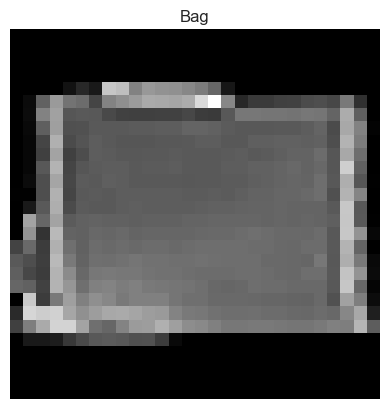

In [21]:
# test

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

sample_idx = 105
x, y = test_data[sample_idx][0], test_data[sample_idx][1]

img, label = test_data[sample_idx]
plt.title(classes[label])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [22]:
model.eval()

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    pred_probab = nn.Softmax(dim=1)(pred)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    print('------\nProbabilities (estimated):')
    for i,p in enumerate(list(pred_probab[0].cpu().numpy())):
        with np.printoptions(precision=3, suppress=True):
            print(classes[i],":",format(p, ".2f"))

Predicted: "Bag", Actual: "Bag"
------
Probabilities (estimated):
T-shirt/top : 0.00
Trouser : 0.00
Pullover : 0.00
Dress : 0.00
Coat : 0.00
Sandal : 0.00
Shirt : 0.00
Sneaker : 0.00
Bag : 1.00
Ankle boot : 0.00


Key Changes:


Architecture:
Added a new fully connected layer.
Increased the number of neurons in the hidden layers.
Switched the activation function to LeakyReLU for improved performance.

Training Procedure:
Increased the number of epochs to 20.
Decreased batch size to 32 for finer gradient updates.
Changed the optimizer to Adam for adaptive learning rate adjustments.
NB.!!!! The mprovements in performance depend on the hardware and dataset-specific characteristics. 

Compare the accuracy after training and testing.

<hr>

## (C) Exercise on MLP Linear Classification

In this exercise, you are required to develop a classfier for the [QMNIST dataset](https://github.com/facebookresearch/qmnist), consisting of handwritten digits. You are entirely free to use any architecture you like. Consider using the [QMNIST torchvision dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.QMNIST.html#torchvision.datasets.QMNIST).

I encourage you to implement the [LeNet-5 architecture from this tutorial](https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html). [See here for a primer on Convolutional Neural Networks (CNNs)](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

LeNet-5 is a classical convolutional neural network (CNN) designed for handwritten digit classification, and it’s well-suited for this task. The network contains two convolutional layers followed by subsampling (pooling) and two fully connected layers.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Download and Preprocess the QMNIST Dataset

The QMNIST dataset consists of grayscale images (1 channel) of size 28x28. We’ll normalize the pixel values for better training stability.

In [3]:
# Define the transformation: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std dev used for MNIST-like data
])

# Load the QMNIST dataset
train_data = datasets.QMNIST(root="data", what='train', download=True, transform=transform)
test_data = datasets.QMNIST(root="data", what='test', download=True, transform=transform)

# Define batch size
batch_size = 64

# Create DataLoader for train and test datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Implement the LeNet-5 Architecture

In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 1 input channel (grayscale), 6 output channels (filters), 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 6 input channels, 16 output channels
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # input from last conv layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output classes for digits 0-9

    def forward(self, x):
        # Apply first convolution, then pooling, then ReLU activation
        x = self.pool(torch.relu(self.conv1(x)))
        # Apply second convolution, then pooling, then ReLU activation
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten the tensor into a vector for fully connected layers
        x = x.view(-1, 16 * 4 * 4)
        # Pass through fully connected layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Output layer with no activation (for use with CrossEntropyLoss)
        x = self.fc3(x)
        return x

# Instantiate the model and move it to the device (GPU or CPU)
model = LeNet5().to(device)
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Define the Loss Function and Optimizer

For this classification task, we use the cross-entropy loss function and the Adam optimizer.

In [5]:
# Define the loss function (CrossEntropyLoss) and optimizer (Adam)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the Model

In [6]:
def train(model, train_loader, loss_function, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            pred = model(X)
            loss = loss_function(pred, y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Train the model for 10 epochs
train(model, train_loader, loss_function, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.2430
Epoch [2/10], Loss: 0.0723
Epoch [3/10], Loss: 0.0526
Epoch [4/10], Loss: 0.0420
Epoch [5/10], Loss: 0.0338
Epoch [6/10], Loss: 0.0292
Epoch [7/10], Loss: 0.0255
Epoch [8/10], Loss: 0.0211
Epoch [9/10], Loss: 0.0191
Epoch [10/10], Loss: 0.0174


Test the Model

In [9]:
def test(model, test_loader, loss_function):
    model.eval()  # Set model to evaluation mode
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            total_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = correct / len(test_loader.dataset)
    avg_loss = total_loss / len(test_loader)
    accuracy_percentage = accuracy * 100
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f} ({accuracy_percentage:.2f}%)")

# Test the model
test(model, test_loader, loss_function)

Test Loss: 0.0497, Accuracy: 0.99 (98.67%)


Visualize the Predictions

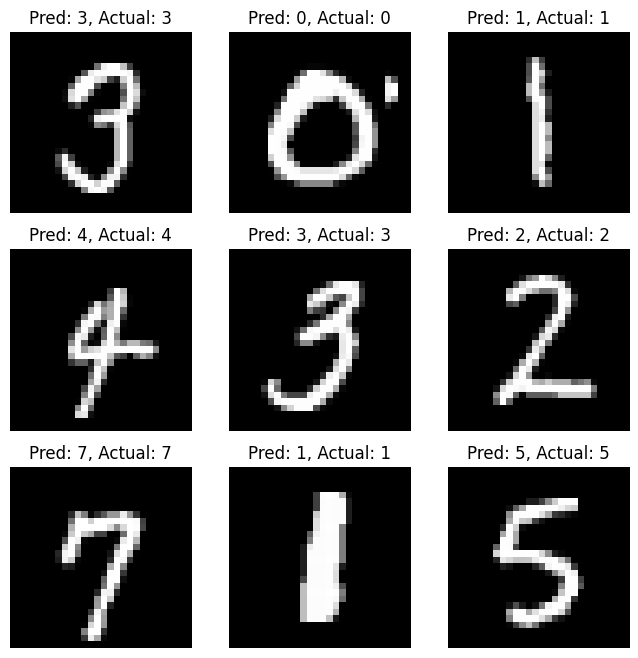

In [8]:
def visualize_predictions(model, test_loader):
    model.eval()
    fig = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    with torch.no_grad():
        for i in range(1, cols * rows + 1):
            sample_idx = torch.randint(len(test_loader.dataset), size=(1,)).item()
            img, label = test_loader.dataset[sample_idx]
            img = img.unsqueeze(0).to(device)  # Add batch dimension
            
            pred = model(img)
            predicted_label = pred.argmax(1).item()

            fig.add_subplot(rows, cols, i)
            plt.title(f'Pred: {predicted_label}, Actual: {label}')
            plt.axis("off")
            plt.imshow(img.squeeze().cpu(), cmap="gray")
    
    plt.show()

visualize_predictions(model, test_loader)

Summary:

* Model: LeNet-5, a classical convolutional neural network (CNN) architecture with 2 convolutional layers and 2 fully connected layers.
* Dataset: QMNIST dataset of handwritten digits.
* Training Setup: Adam optimizer and CrossEntropyLoss for 10 epochs with batch size 64.